# *Sarcasm Detection using KNN*

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics, neighbors
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
header = pd.read_csv(r"drive/My Drive/Colab_Notebooks/Data/key.csv",sep='\t',header=None).transpose()[0].tolist()
train = pd.read_csv(r"drive/My Drive/Colab_Notebooks/Data/train-balanced.csv",sep='\t',names = header)
test = pd.read_csv(r"drive/My Drive/Colab_Notebooks/Data/test-balanced.csv",sep='\t',names = header)

In [4]:
header = pd.read_csv(r"C:\Users\Vipre\Data\key.csv",sep='\t',header=None).transpose()[0].tolist()
test = pd.read_csv(r"C:\Users\Vipre\Data\test-balanced.csv",sep='\t',names = header)
train = pd.read_csv(r"C:\Users\Vipre\Data\train-balanced.csv",sep='\t',names = header)

In [5]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251608 entries, 0 to 251607
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   label           251608 non-null  int64 
 1   comment         251594 non-null  object
 2   author          251608 non-null  object
 3   subreddit       251608 non-null  object
 4   score           251608 non-null  int64 
 5   ups             251608 non-null  int64 
 6   downs           251608 non-null  int64 
 7   date            251608 non-null  object
 8   created_utc     251608 non-null  int64 
 9   parent_comment  251608 non-null  object
dtypes: int64(5), object(5)
memory usage: 19.2+ MB


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,Actually most of her supporters and sane peopl...,Quinnjester,politics,3,3,0,2016-09,1473569605,Hillary's Surrogotes Told to Blame Media for '...
1,0,They can't survive without an echo chamber whi...,TheGettysburgAddress,The_Donald,13,-1,-1,2016-11,1478788413,Thank God Liberals like to live in concentrate...
2,0,you're pretty cute yourself 1729 total,Sempiternally_free,2007scape,8,-1,-1,2016-11,1478042903,Saw this cutie training his Attack today...
3,0,If you kill me you'll crash the meme market,Catacomb82,AskReddit,2,-1,-1,2016-10,1477412597,If you were locked in a room with 49 other peo...
4,0,I bet he wrote that last message as he was sob...,Dorian-throwaway,niceguys,5,-1,-1,2016-11,1477962278,You're not even that pretty!


In [6]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  int64 
 9   parent_comment  1010826 non-null  object
dtypes: int64(5), object(5)
memory usage: 77.1+ MB


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,1476662123,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,1477959850,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,1474580737,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,1476824627,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,1483117213,Yep can confirm I saw the tool they use for th...


In [10]:
train.describe()

,label,score,ups,downs,created_utc
count,1010826.0,1.010826e+06,1.010826e+06,1.010826e+06,1.010826e+06
mean,0.5,6.885676e+00,5.498885e+00,-1.458629e-01,1.438684e+09
std,0.5,4.834288e+01,4.127297e+01,3.529689e-01,3.945812e+07
min,0.0,-5.070000e+02,-5.070000e+02,-1.000000e+00,1.230851e+09
25%,0.0,1.000000e+00,0.000000e+00,0.000000e+00,1.420734e+09
50%,0.5,2.000000e+00,1.000000e+00,0.000000e+00,1.448915e+09
75%,1.0,4.000000e+00,3.000000e+00,0.000000e+00,1.468588e+09
max,1.0,9.070000e+03,5.163000e+03,0.000000e+00,1.483229e+09


In [11]:
len(train.columns)

10

In [12]:
len(train['label'])

1010826

In [29]:
train['subreddit'].nunique()

14878

In [14]:
train['label'].value_counts()

1    505413
0    505413
Name: label, dtype: int64

In [15]:
train['comment'].nunique()

962294

In [16]:
train.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [17]:
test.isnull().sum()

label              0
comment           14
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [18]:
train.corr()

,label,score,ups,downs,created_utc
label,1.000000,-0.010028,-0.006697,0.057546,-0.057547
score,-0.010028,1.000000,0.849238,-0.013864,0.016939
ups,-0.006697,0.849238,1.000000,0.065070,-0.014934
downs,0.057546,-0.013864,0.065070,1.000000,-0.426066
created_utc,-0.057547,0.016939,-0.014934,-0.426066,1.000000


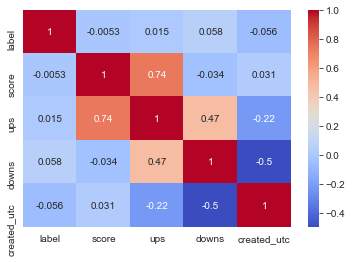

In [37]:
corr = train.corr(method = 'kendall')
sns.heatmap(corr,annot = True,cmap='coolwarm')

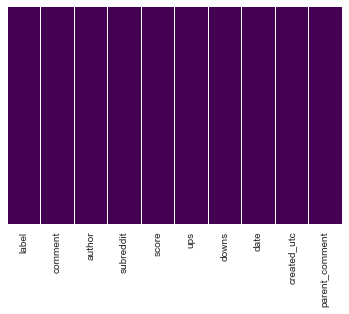

In [41]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

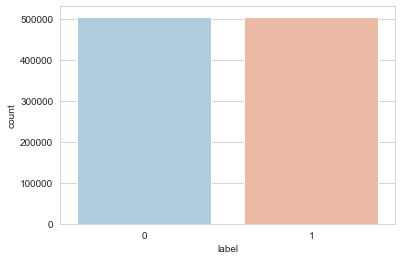

In [24]:
sns.set_style('whitegrid')
sns.countplot(x='label',data=train,palette='RdBu_r')

In [ ]:
sns.pairplot(train,hue='label',palette='Set1')

In [32]:
train.dropna(axis=0,inplace=True)

In [33]:
test.dropna(axis=0, inplace=True)

In [18]:
train['comment'] = train.comment.map(lambda x: x.lower())
test['comment'] = test.comment.map(lambda x: x.lower())

In [19]:
train['comment'] = train.comment.str.replace('[^\w\s]', '')
test['comment'] = test.comment.str.replace('[^\w\s]', '')

In [42]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vipre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vipre\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [57]:
#from nltk.tokenize import sent_tokenize, word_tokenize
#ps = PorterStemmer()
#for w in text:
#	rootWord=ps.stem(w)

In [58]:
nlp = spacy.load("en_core_web_sm")
#nlp.max_length = 101100
#train['comment'].to_string()
#doc = nlp(train['comment'])
#lemma_list = []
#for token in doc:
#    lemma_list.append(token.lemma_)

In [59]:
#train['comment'] = train['comment'].apply(spacy.token)
#train['comment'] = train['comment'].apply(lambda x: [token.lemma_(y) for y in x])

In [43]:
word_lemma = WordNetLemmatizer()

In [53]:
def clean(text):
  token = nltk.word_tokenize(text)
  for w in token:
    (w, word_lemma.lemmatize(w))
  return " ".join(text)


In [54]:
train['comment'] = train['comment'].apply(lambda x: clean(x))
test['comment'] = test['comment'].apply(lambda x: clean(x))

In [55]:
len(train['label'])

1010773

In [28]:
train.head()
train['comment']

0                                                  nc and nh
1          you do know west team play against west team m...
2          they were underdog earlier today but sinc gron...
3          thi meme isnt funni none of the new york nigga...
4                              i could use one of those tool
                                 ...                        
1010821    im sure that iran and n korea have the technol...
1010822                        whatev you do dont vote green
1010823    perhap thi is an atheist conspiraci to make ch...
1010824     the slav got their own countri it is call kosovo
1010825    valu as in capit there is good money in impris...
Name: comment, Length: 1010773, dtype: object

In [29]:
count_vect = CountVectorizer()

In [30]:
count_vect = CountVectorizer(max_features = 500000, lowercase=True, stop_words='english', min_df=2)

In [31]:
train_counts = count_vect.fit_transform(train['comment'])

In [33]:
transformer = TfidfTransformer().fit(train_counts)

In [34]:
train_tfidf = transformer.transform(train_counts)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train_tfidf, train['label'], test_size=0.3,random_state=4)

In [36]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', p=1,
                                         metric='minkowski', metric_params=None, n_jobs=-1)

In [37]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=1,
                     weights='uniform')

In [38]:
predicted = knn.predict(X_test)

In [39]:
acc = metrics.accuracy_score(y_test, predicted)
print('KNN accuracy = ' + str(acc * 100) + '%')

KNN accuracy = 59.5168056141832%


In [40]:
con_mat = confusion_matrix(y_test, predicted, [0, 1])

In [41]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.57      0.77      0.66    151589
           1       0.65      0.42      0.51    151643

    accuracy                           0.60    303232
   macro avg       0.61      0.60      0.58    303232
weighted avg       0.61      0.60      0.58    303232



In [42]:
matrix = confusion_matrix(y_test, predicted)
print(matrix)

[[117416  34173]
 [ 88585  63058]]


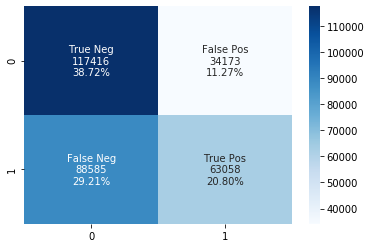

In [43]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt="", cmap='Blues')

In [60]:
knn.score(y_test,predictions)

In [68]:
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [75]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')